In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
from IPython.display import Javascript

2023-11-16 18:16:43.141432: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 18:16:43.235334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import tensorflow as tf

# Check GPUs available
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs Available: {gpus}")

# Check if TensorFlow is currently executing eagerly (which means operations are executed as they are defined and is the default mode in TF 2.x)
print(f"Eager execution: {tf.executing_eagerly()}")

# If you have GPUs listed and eager execution is enabled, then operations should automatically run on the GPU if possible.
# To test if TensorFlow will place tensors and operations on the GPU by default, you can create a simple operation and see where it is placed:
if gpus:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        print(a.device)
else:
    print("No GPU found!")


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Eager execution: True
/job:localhost/replica:0/task:0/device:GPU:0


2023-11-16 18:16:52.039115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 18:16:52.062005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 18:16:52.062330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
data_path = '../ntuples/'
filenames = ['ntuples.h5', 'MC_HHbbttHadHad_ntuples.h5', 'MC_ZZ4lep_ntuples.h5', 'MC_Ztautau_ntuples.h5', 'MC_jj_ntuples.h5', 'MC_jj_JZ3_ntuples.h5', 'MC_qqa_ntuples.h5']
tags = ['data', 'HHbbttHadHad', 'ZZ4lep', 'Ztautau', 'jj_JZ4', 'jj_JZ3', 'qqa']
dataset_names = ["jets", "electrons", "muons", "photons", "MET"]

In [6]:
# Make a list that contains the ndarrays for each dataset
datasets = []

for filename in filenames:
    with h5py.File(data_path+filename, 'r') as hf:
        jets = hf['jets'][:]
        electrons = hf['electrons'][:]
        muons = hf['muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET

        combined_data = np.concatenate([jets, electrons, muons, photons, MET], axis=1)
        datasets.append(combined_data)

In [7]:
for i, dataset in enumerate(datasets):
    print(f'{tags[i]}: {dataset.shape}')

data: (1294420, 20, 4)
HHbbttHadHad: (10000, 20, 4)
ZZ4lep: (9998, 20, 4)
Ztautau: (39901, 20, 4)
jj_JZ4: (5000, 20, 4)
jj_JZ3: (10000, 20, 4)
qqa: (30000, 20, 4)


In [8]:
print(f'Example data:\n{datasets[0][9]}')

Example data:
[[ 2.58181190e+01  4.50975464e+02 -3.55259347e+00  1.38344622e+00]
 [ 1.96157665e+01  7.58217926e+01  2.02612805e+00  2.88564324e+00]
 [ 1.71844158e+01  6.48804550e+01 -2.00229001e+00 -2.16885233e+00]
 [ 1.60912628e+01  6.71055603e+01  2.10529757e+00 -1.07255232e+00]
 [ 1.55162134e+01  4.55187263e+01  1.73604524e+00 -2.75335526e+00]
 [ 1.27152538e+01  1.80407143e+01 -8.67513359e-01  5.81147850e-01]
 [ 1.07990074e+01  2.18484249e+01  1.32434070e+00  1.11649776e+00]
 [ 9.73729134e+00  2.50739079e+01 -1.59475589e+00  3.48966300e-01]
 [ 7.73750591e+00  8.91839600e+00  5.05040765e-01 -1.26650226e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+0

In [9]:
# pt cuts and MET bias

f_datasets = []
for data in datasets:

    # pt
    first_jet_pts = data[:, 0, 0]

    # Filter events where the highest pt jet has pt > 2000
    pt_mask = (first_jet_pts <= 2000) & ((first_jet_pts >= 20) | (first_jet_pts == 0))
    filtered_data = data[pt_mask, :, :]

    # MET: 0 --> 0.001 and -999 --> 0
    MET_zeros = (filtered_data[:, 19, 0] == 0)
    MET_999 = ((filtered_data[:, 19, 0] == -999))
    filtered_data[MET_zeros, 19, 0] = 0.001
    filtered_data[MET_999, 19, :] = 0

    print(f'original data: {data.shape}')
    print(f'filtered data: {filtered_data.shape}')
    f_datasets.append(filtered_data)

original data: (1294420, 20, 4)
filtered data: (1256561, 20, 4)
original data: (10000, 20, 4)
filtered data: (10000, 20, 4)
original data: (9998, 20, 4)
filtered data: (9709, 20, 4)
original data: (39901, 20, 4)
filtered data: (36528, 20, 4)
original data: (5000, 20, 4)
filtered data: (5000, 20, 4)
original data: (10000, 20, 4)
filtered data: (10000, 20, 4)
original data: (30000, 20, 4)
filtered data: (29996, 20, 4)


In [10]:
print(f'Example data:\n{f_datasets[0][9]}')

Example data:
[[ 2.58181190e+01  4.50975464e+02 -3.55259347e+00  1.38344622e+00]
 [ 1.96157665e+01  7.58217926e+01  2.02612805e+00  2.88564324e+00]
 [ 1.71844158e+01  6.48804550e+01 -2.00229001e+00 -2.16885233e+00]
 [ 1.60912628e+01  6.71055603e+01  2.10529757e+00 -1.07255232e+00]
 [ 1.55162134e+01  4.55187263e+01  1.73604524e+00 -2.75335526e+00]
 [ 1.27152538e+01  1.80407143e+01 -8.67513359e-01  5.81147850e-01]
 [ 1.07990074e+01  2.18484249e+01  1.32434070e+00  1.11649776e+00]
 [ 9.73729134e+00  2.50739079e+01 -1.59475589e+00  3.48966300e-01]
 [ 7.73750591e+00  8.91839600e+00  5.05040765e-01 -1.26650226e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+0

In [11]:
# Calculate pt sum of each event
pt_sums = []

for i, data in enumerate(f_datasets):
    pt_sums.append(np.sum(data[:, :, 0], axis=1))

In [12]:
# Figure out how big the pt is compared to other variables:
for i, data in enumerate(f_datasets):
    row_sum = np.sum(np.absolute(data[:, 0:19, :]), axis=1)
    medians = np.median(row_sum, axis=0)
    print(f'{tags[i]} medians: {medians}')

data medians: [ 294.31223297 1414.35587788   14.05920625   14.91676779]
HHbbttHadHad medians: [ 593.42202616 1485.07065189   18.4368468    22.08619483]
ZZ4lep medians: [ 398.02820873 1053.60963678   19.12409309   22.07256185]
Ztautau medians: [181.83789968 924.55331707  14.43168325  15.05155629]
jj_JZ4 medians: [1841.19115496 3083.30823825   16.93984805   20.47628147]
jj_JZ3 medians: [ 751.36850142 2451.38589166   18.39553753   18.57009314]
qqa medians: [ 371.26037216 1100.72912684   17.03153279   18.90476364]


In [13]:
# Normalize Jets and E/m
norm_datasets = []
for i, data in enumerate(f_datasets):
    norm_data = np.zeros_like(data)
    norm_data[:, 19, :] = data[:, 19, :]
    norm_data[:, :19, 0] = data[:, :19, 0] / 20
    norm_data[:, :19, 1] = data[:, :19, 1] / 100
    norm_data[:, :, 2:4] = data[:, :, 2:4]
    norm_datasets.append(norm_data)

In [14]:
# Figure out how big the pt is compared to other variables:
for i, data in enumerate(norm_datasets):
    row_sum = np.sum(np.absolute(data[:, 0:19, :]), axis=1)
    medians = np.median(row_sum, axis=0)
    print(f'{tags[i]} medians: {medians}')

data medians: [14.71561165 14.14355878 14.05920625 14.91676779]
HHbbttHadHad medians: [29.67110131 14.85070652 18.4368468  22.08619483]
ZZ4lep medians: [19.90141044 10.53609637 19.12409309 22.07256185]
Ztautau medians: [ 9.09189498  9.24553317 14.43168325 15.05155629]
jj_JZ4 medians: [92.05955775 30.83308238 16.93984805 20.47628147]
jj_JZ3 medians: [37.56842507 24.51385892 18.39553753 18.57009314]
qqa medians: [18.56301861 11.00729127 17.03153279 18.90476364]


In [15]:
print(f'Example data:\n{norm_datasets[0][9]}')

Example data:
[[ 1.29090595  4.50975464 -3.55259347  1.38344622]
 [ 0.98078833  0.75821793  2.02612805  2.88564324]
 [ 0.85922079  0.64880455 -2.00229001 -2.16885233]
 [ 0.80456314  0.6710556   2.10529757 -1.07255232]
 [ 0.77581067  0.45518726  1.73604524 -2.75335526]
 [ 0.63576269  0.18040714 -0.86751336  0.58114785]
 [ 0.53995037  0.21848425  1.3243407   1.11649776]
 [ 0.48686457  0.25073908 -1.59475589  0.3489663 ]
 [ 0.3868753   0.08918396  0.50504076 -1.26650226]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.

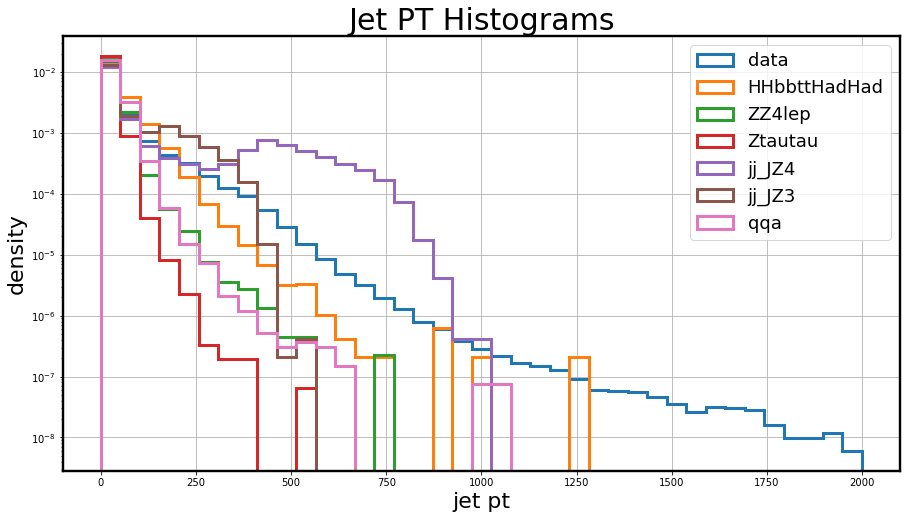

In [16]:
plt.figure(figsize=(15, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins = np.linspace(0, 2000, 40)
#bins=25

for i, tag in enumerate(tags):
    pt = f_datasets[i][:, :10, 0]
    pt = pt[pt > 0]

    plt.hist(pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3)

plt.yscale('log')
plt.xlabel('jet pt', fontsize=22)
plt.ylabel('density', fontsize=22)
plt.title('Jet PT Histograms', fontsize=30)
plt.grid()
plt.legend(fontsize=18)
plt.show()

In [17]:
# Flatten ndarrays for DNN
flat_datasets = []
for i, data in enumerate(norm_datasets):
    flat_datasets.append(np.reshape(data, newshape=(-1, 80)))

for i, data in enumerate(flat_datasets):
    print(f'{tags[i]}: {data.shape}')

data: (1256561, 80)
HHbbttHadHad: (10000, 80)
ZZ4lep: (9709, 80)
Ztautau: (36528, 80)
jj_JZ4: (5000, 80)
jj_JZ3: (10000, 80)
qqa: (29996, 80)


In [18]:
def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = layers.Dense(h_dim_2, activation='relu')(z)
    x = layers.Dense(h_dim_1, activation='relu')(z)
    outputs = layers.Dense(input_dim)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [19]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    mask = K.cast(K.not_equal(y_true, 0), K.floatx())
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

In [20]:
TRAIN_SIZE = 0.6
VAL_SIZE = 0.2
TEST_SIZE = 0.2

In [21]:
X_train, X_, pt_sum_train, pt_sum_ = train_test_split(flat_datasets[0], pt_sums[0], train_size=TRAIN_SIZE)
X_val, X_test, pt_sum_val, pt_sum_test = train_test_split(X_, pt_sum_, train_size=0.5)
pt_sums[0] = pt_sum_test

print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')

X_train: (753936, 80)
X_val: (251312, 80)
X_test: (251313, 80)


In [22]:
# Initialize model
INPUT_DIM = X_train.shape[1]
H_DIM_1 = 32
H_DIM_2 = 16
LATENT_DIM = 8
DNN_AE = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
DNN_AE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80)]              0         
                                                                 
 dense (Dense)               (None, 32)                2592      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 32)                288       
                                                                 
 dense_5 (Dense)             (None, 80)                2640      
                                                                 
Total params: 6,184
Trainable params: 6,184
Non-trainable par

In [23]:
DNN_AE.compile(optimizer='adam', loss=loss_fn)

In [24]:
STOP_PATIENCE = 8
LR_PATIENCE = 4

In [25]:
early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [26]:
NUM_EPOCHS = 50
BATCH_SIZE = 1024

In [39]:
history = DNN_AE.fit(x=X_train, y=X_train, validation_data=(X_val, X_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/50


2023-11-16 01:11:48.387897: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb49c005cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-16 01:11:48.388003: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-11-16 01:11:48.473219: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-16 01:11:50.102796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-11-16 01:11:51.250860: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


737/737 [==============================] - 22s 8ms/step - loss: 6.2982 - val_loss: 1.4721 - lr: 0.0010
Epoch 2/50
737/737 [==============================] - 4s 5ms/step - loss: 1.5482 - val_loss: 1.1317 - lr: 0.0010
Epoch 3/50
737/737 [==============================] - 4s 5ms/step - loss: 1.3542 - val_loss: 1.1640 - lr: 0.0010
Epoch 4/50
737/737 [==============================] - 4s 6ms/step - loss: 1.2734 - val_loss: 1.1237 - lr: 0.0010
Epoch 5/50
737/737 [==============================] - 4s 5ms/step - loss: 1.3838 - val_loss: 1.0501 - lr: 0.0010
Epoch 6/50
737/737 [==============================] - 4s 5ms/step - loss: 1.1780 - val_loss: 1.0721 - lr: 0.0010
Epoch 7/50
737/737 [==============================] - 4s 5ms/step - loss: 1.1716 - val_loss: 1.0528 - lr: 0.0010
Epoch 8/50
737/737 [==============================] - 4s 5ms/step - loss: 1.1741 - val_loss: 1.0564 - lr: 0.0010
Epoch 9/50
737/737 [==============================] - 4s 5ms/step - loss: 1.2743 - val_loss: 1.0276 - lr: 

In [40]:
DNN_AE.save('Trained_Models/DNN_1.keras')

In [27]:
custom_objects = {'loss_fn': loss_fn}
loaded_model = load_model('Trained_Models/DNN_1.keras', custom_objects=custom_objects)

In [28]:
predictions = []
y_true = []


predictions.append(loaded_model.predict(X_test))
y_true.append(X_test)

for i, data in enumerate(datasets):
    if i==0: continue

    y_true.append(flat_datasets[i])
    predictions.append(loaded_model.predict(flat_datasets[i]))

938/938 [==============================] - 2s 2ms/step


In [29]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [30]:
def AD_score(y, x):
    # masked mse
    mask = (y != 0)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [31]:
total_loss = []

for i, prediction in enumerate(predictions):
    total_loss.append(AD_score(y_true[i], prediction))

<Figure size 1296x720 with 0 Axes>

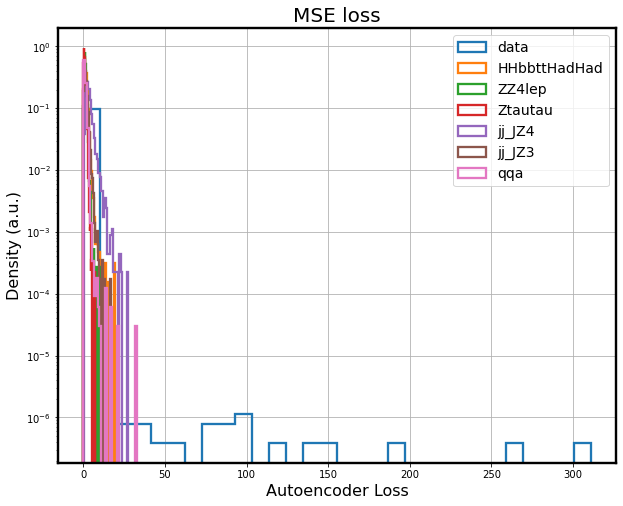

In [32]:
plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 1000000, num=30)
bins=30
plt.figure(figsize=(10,8))
for i, tag in enumerate(tags):
    plt.hist(total_loss[i], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3)


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

<Figure size 720x360 with 0 Axes>

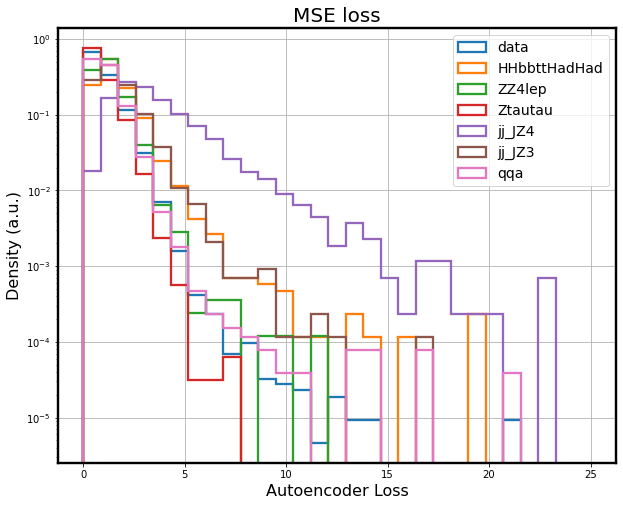

In [33]:
plt.figure(figsize=(10, 5))
plt.rcParams['axes.linewidth'] = 2.4

bins = np.linspace(0, 25, num=30)
#bins=30
plt.figure(figsize=(10,8))
for i, tag in enumerate(tags):
    plt.hist(total_loss[i], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3)


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

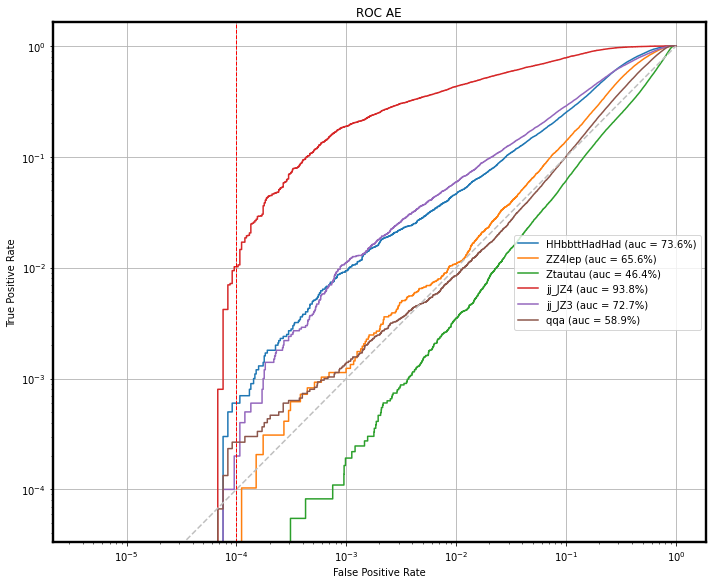

In [34]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(tags):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.0001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()

In [35]:
def remove_outliers(loss, pt_sum):
    q1_loss = np.percentile(loss, 25)
    q3_loss = np.percentile(loss, 75)
    iqr_loss = q3_loss - q1_loss

    q1_pt_sum = np.percentile(pt_sum, 25)
    q3_pt_sum = np.percentile(pt_sum, 75)
    iqr_pt_sum = q3_pt_sum - q1_pt_sum

    lower_bound_loss = q1_loss - 3 * iqr_loss
    upper_bound_loss = q3_loss + 3 * iqr_loss

    lower_bound_pt_sum = q1_pt_sum - 3 * iqr_pt_sum
    upper_bound_pt_sum = q3_pt_sum + 3 * iqr_pt_sum

    mask = (loss >= lower_bound_loss) & (loss <= upper_bound_loss) & \
           (pt_sum >= lower_bound_pt_sum) & (pt_sum <= upper_bound_pt_sum)

    return loss[mask], pt_sum[mask]

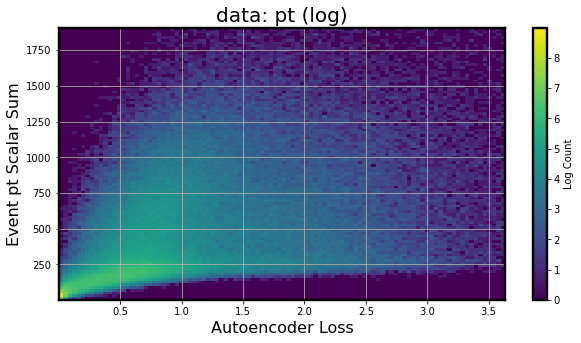

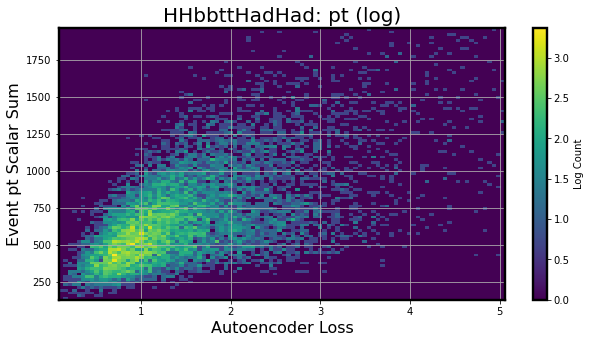

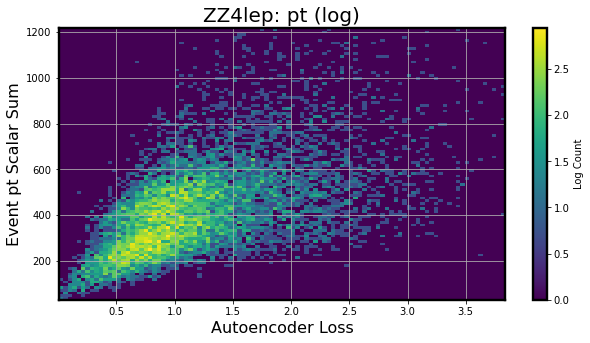

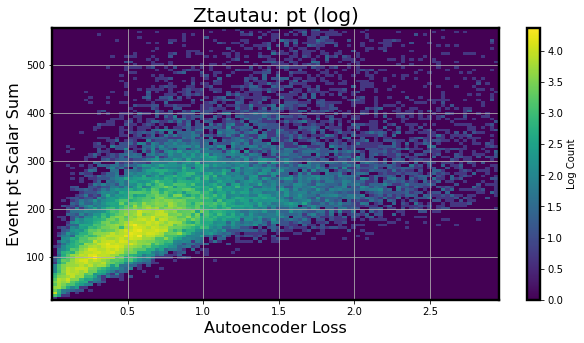

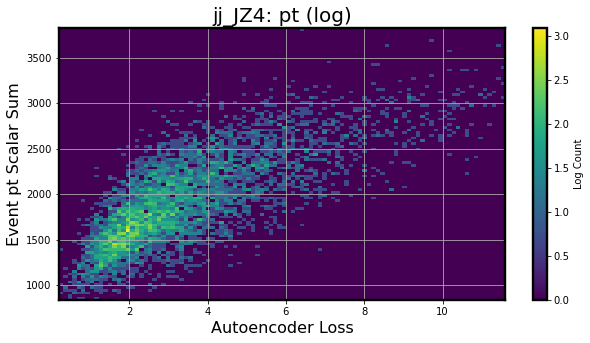

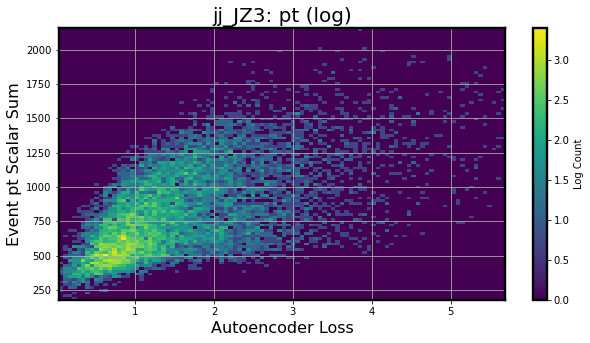

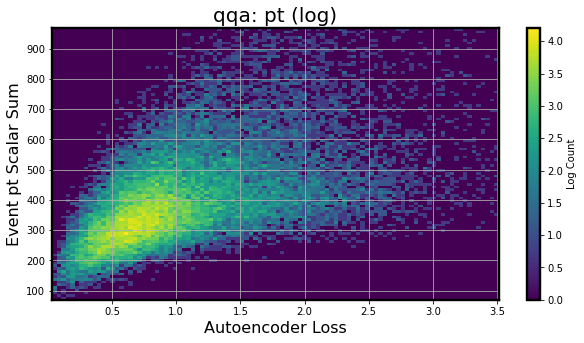

In [36]:
for i, tag in enumerate(tags):
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4

    bins=100

    # Apply the outlier removal to your data
    filtered_total_loss, filtered_sum_pt = remove_outliers(total_loss[i], pt_sums[i])

    # Use numpy to get the histogram data
    counts, xedges, yedges = np.histogram2d(x=filtered_total_loss, y=filtered_sum_pt, bins=bins)

    # Take the logarithm of the counts
    counts_log = np.log(counts + 1)  # Add 1 to avoid log(0)

    # Plot the log of the counts
    plt.pcolormesh(xedges, yedges, counts_log.T, shading='auto')  # Transpose counts to align with x/y edges

    plt.colorbar(label='Log Count')
    plt.title(f'{tag}: pt (log)', fontsize=20)
    plt.xlabel("Autoencoder Loss", fontsize=16)
    plt.ylabel("Event pt Scalar Sum", fontsize=16)
    plt.grid()
    plt.show()

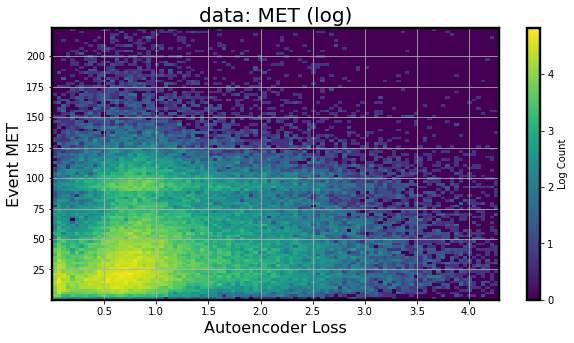

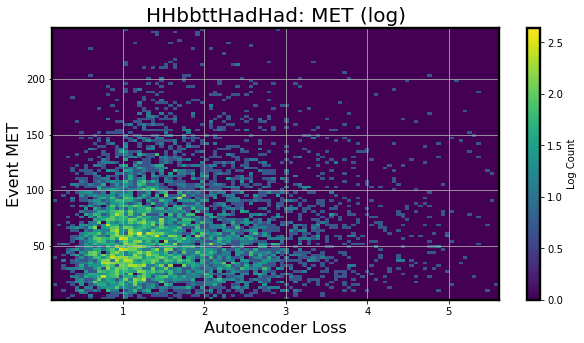

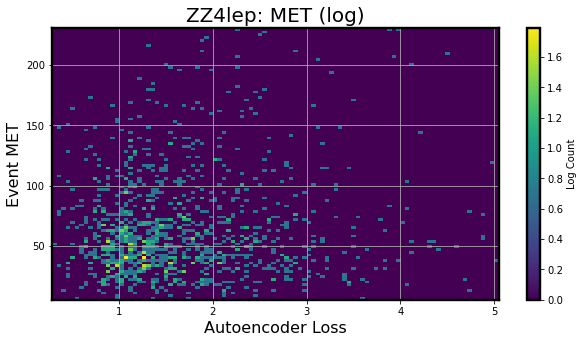

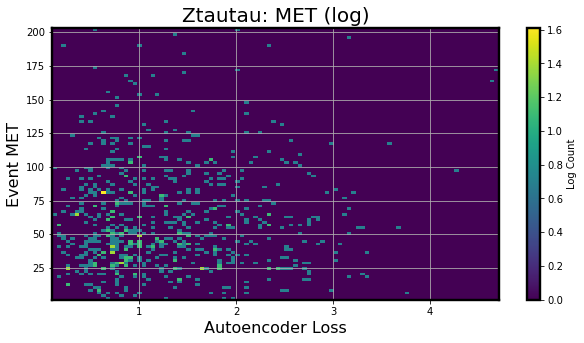

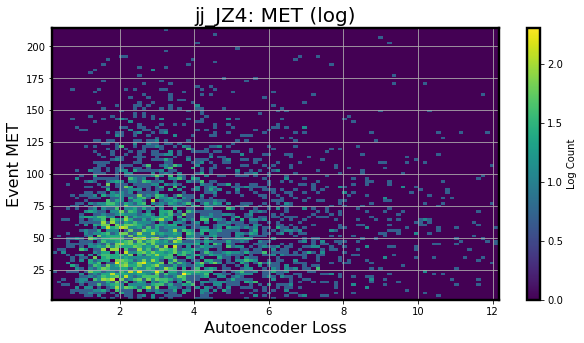

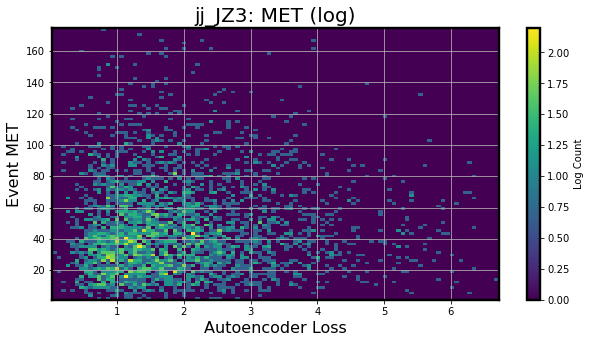

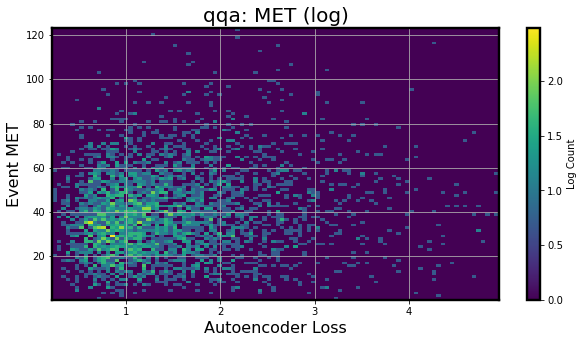

In [37]:
for i, tag in enumerate(tags):
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    
    MET = np.reshape(y_true[i], (-1, 20, 4))[:, 19, 0]
    loss = total_loss[i][MET > 0]
    MET = MET[MET > 0]

    # Apply the outlier removal to your data
    filtered_total_loss, filtered_MET = remove_outliers(loss, MET)
    
    # Use numpy to get the histogram data
    counts, xedges, yedges = np.histogram2d(x=filtered_total_loss, y=filtered_MET, bins=bins)
    
    # Take the logarithm of the counts
    counts_log = np.log(counts + 1)  # Add 1 to avoid log(0)
    
    # Plot the log of the counts
    plt.pcolormesh(xedges, yedges, counts_log.T, shading='auto')  # Transpose counts to align with x/y edges
    
    plt.colorbar(label='Log Count')
    plt.title(f'{tag}: MET (log)', fontsize=20)
    plt.xlabel("Autoencoder Loss", fontsize=16)
    plt.ylabel("Event MET", fontsize=16)
    plt.grid()
    plt.show()

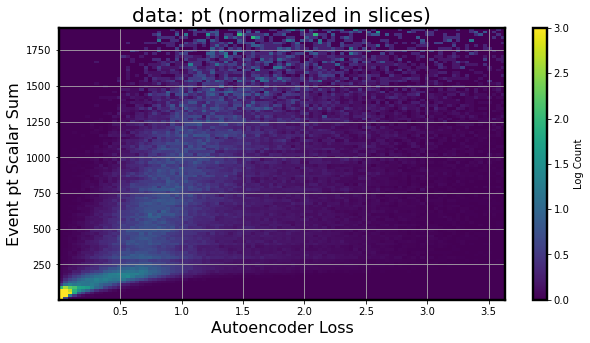

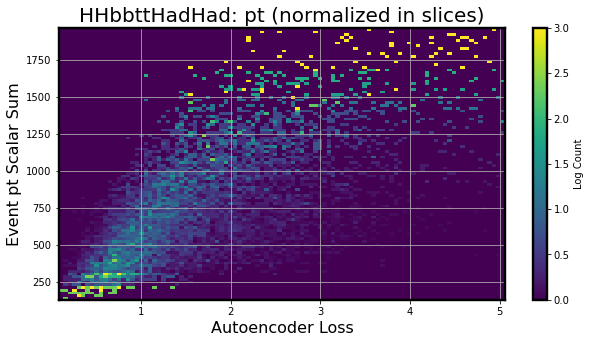

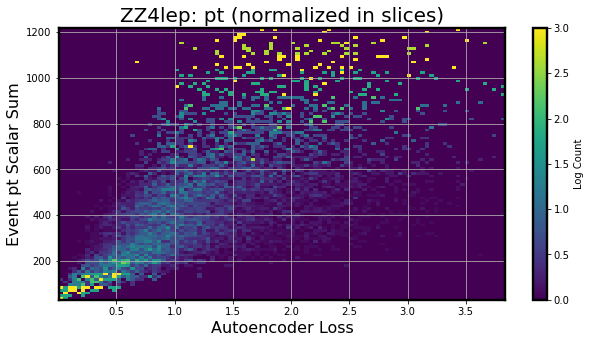

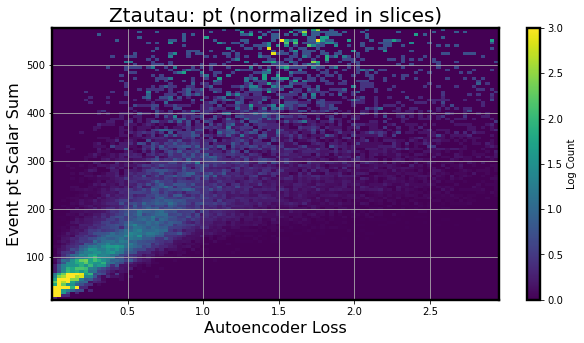

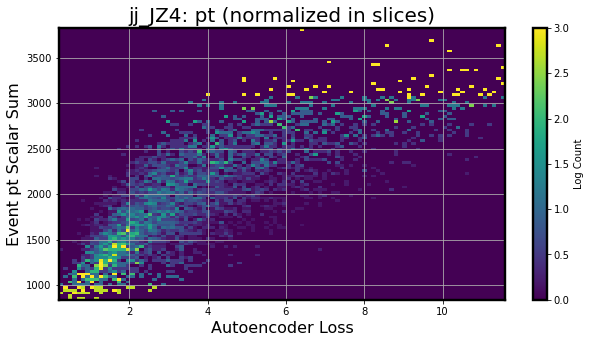

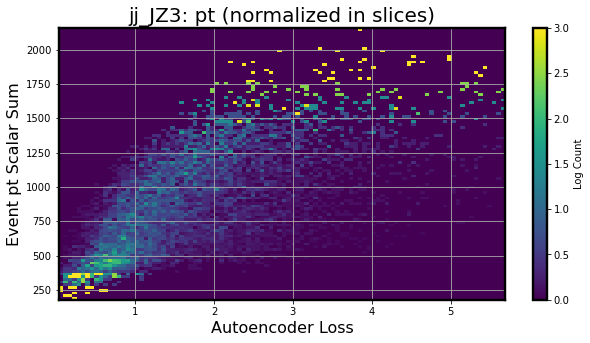

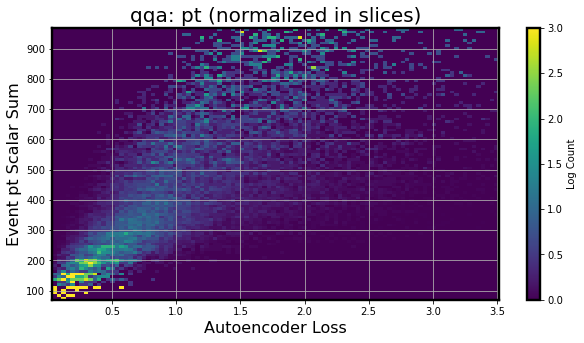

In [55]:
for i, tag in enumerate(tags):
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4

    bins=100

    # Apply the outlier removal to your data
    filtered_total_loss, filtered_sum_pt = remove_outliers(total_loss[i], pt_sums[i])

    # Use numpy to get the histogram data
    counts, xedges, yedges = np.histogram2d(x=filtered_total_loss, y=filtered_sum_pt, bins=bins)

    idx = 0
    rows = 5
    for i in range(counts.shape[1]):
        if idx+rows > counts.shape[1]:
            _sum = np.sum(counts[:, idx:])
            counts[:, idx:] = 100 * counts[:, idx:] / _sum
            break
        else:
            _sum = np.sum(counts[:, idx:idx+rows])
            counts[:, idx:idx+rows] = 100 * counts[:, idx:idx+rows] / _sum
            idx += rows

    counts[counts > 3] = 3

    # Plot the log of the counts
    plt.pcolormesh(xedges, yedges, counts.T, shading='auto')  # Transpose counts to align with x/y edges

    plt.colorbar(label='Log Count')
    plt.title(f'{tag}: pt (normalized in slices)', fontsize=20)
    plt.xlabel("Autoencoder Loss", fontsize=16)
    plt.ylabel("Event pt Scalar Sum", fontsize=16)
    plt.grid()
    plt.show()

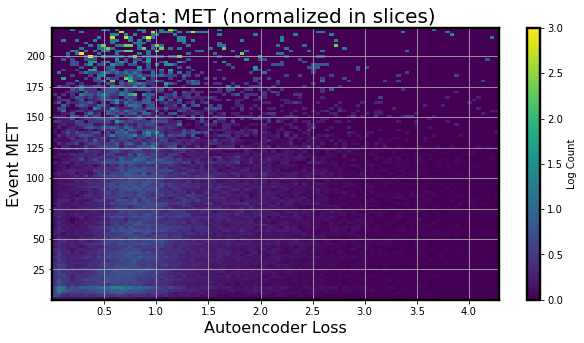

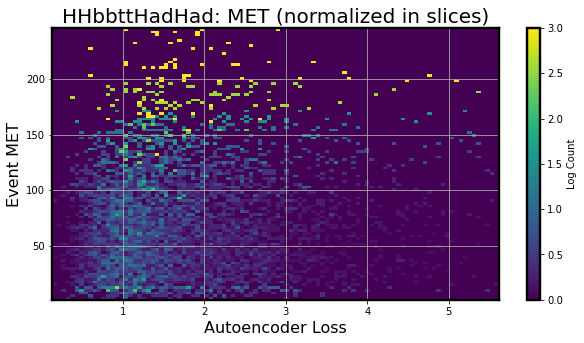

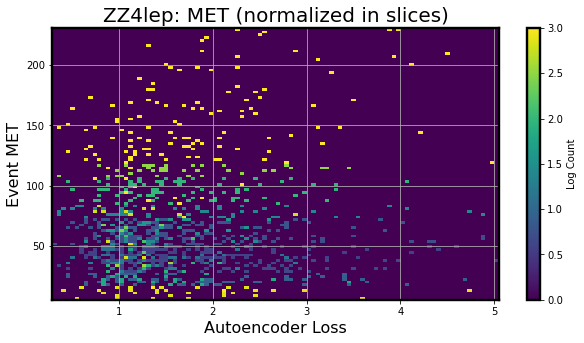

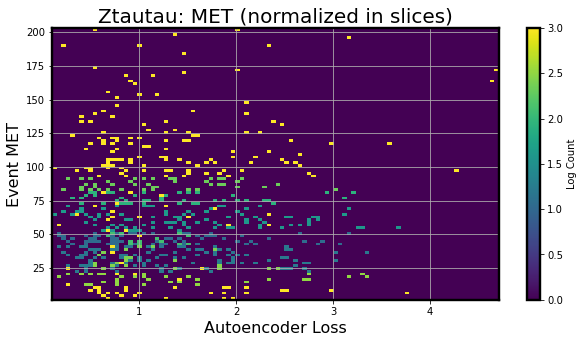

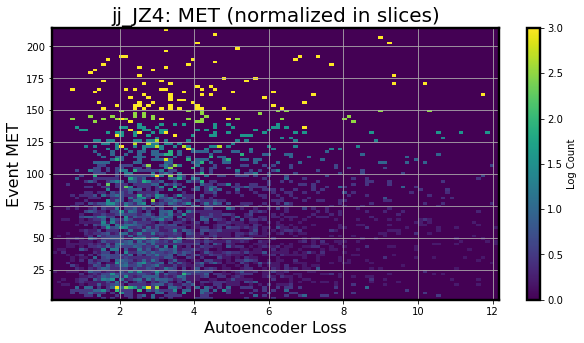

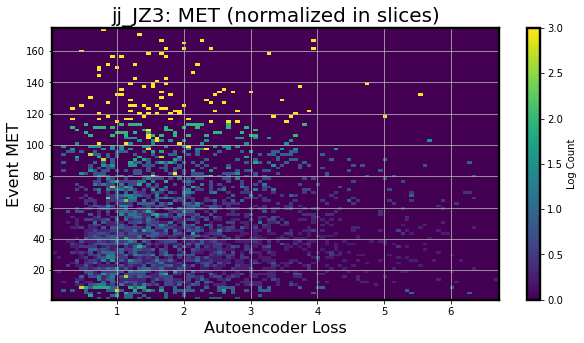

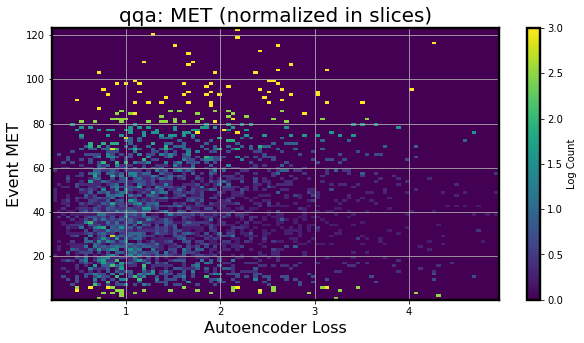

In [60]:
for i, tag in enumerate(tags):
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    
    MET = np.reshape(y_true[i], (-1, 20, 4))[:, 19, 0]
    loss = total_loss[i][MET > 0]
    MET = MET[MET > 0]

    # Apply the outlier removal to your data
    filtered_total_loss, filtered_MET = remove_outliers(loss, MET)
    
    # Use numpy to get the histogram data
    counts, xedges, yedges = np.histogram2d(x=filtered_total_loss, y=filtered_MET, bins=bins)
    
    idx = 0
    rows = 5
    for i in range(counts.shape[1]):
        if idx+rows > counts.shape[1]:
            _sum = np.sum(counts[:, idx:])
            counts[:, idx:] = 100 * counts[:, idx:] / _sum
            break
        else:
            _sum = np.sum(counts[:, idx:idx+rows])
            counts[:, idx:idx+rows] = 100 * counts[:, idx:idx+rows] / _sum
            idx += rows
            
    counts[counts > 3] = 3
    
    # Plot the log of the counts
    plt.pcolormesh(xedges, yedges, counts.T, shading='auto')  # Transpose counts to align with x/y edges
    
    plt.colorbar(label='Log Count')
    plt.title(f'{tag}: MET (normalized in slices)', fontsize=20)
    plt.xlabel("Autoencoder Loss", fontsize=16)
    plt.ylabel("Event MET", fontsize=16)
    plt.grid()
    plt.show()